<a href="https://colab.research.google.com/github/elianaprosnitz/bio108tutorial/blob/main/Code_Tutorial_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can we investigate the impact of wildfires on rare species richness in California?

This tutorial explores the question of how wildfires in California are impacting terrestrial species richness. With the concerning increase in CA wildfires, this exploration will shed light on how these disasters are impacting biodiversity. It is particularly important to know how fire history impacts our more vulnerable, rare species.

Tutorial Quick Access: https://tinyurl.com/ElianaCodeTutorial

### Previous literature: What is a sensible framework for analyzing wildfire impact?

**Burkle et al. (2015)** performed a similar study, looking at wildfire disturbances as drivers of plant species diversity. While not focusing on terrestrial species, the paper set a useful precedent for studying the relationship between wildfires and ecosystem productivity.

**Major question(s):** How does wildfire severity influence spatial patterns of plant species diversity across a large-scale gradient of climate and productivity in the Northern Rockies Ecoregion (NRE) of the western United States?

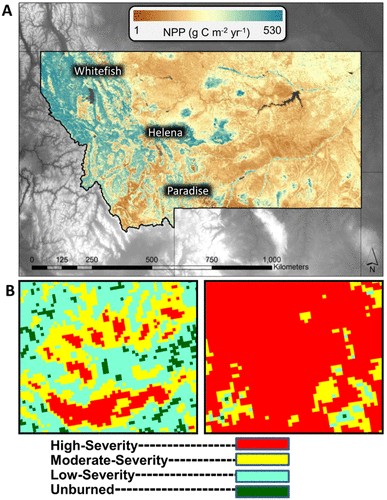

**Hypotheses:**
1.   Communities that burned with high-severity fires would have low local species richness at low productivity but high local species richness at high productivity.
2.   Beta-diversity would be higher across landscapes with mixed-severity fires compared to landscapes with high-severity fires, but that the strength of this pattern would vary depending on productivity.

**Findings:**
Found that beta-diversity (community dispersion) of forbs was higher in mixed-severity compared to high-severity fire, regardless of productivity. Counter to predictions, local species richness was higher in burned landscapes compared to unburned landscapes at the low-productivity site, but lower in burned landscapes at the high-productivity site.

Burkle, L. A., J. A. Myers, and R. T. Belote. 2015. [Wildfire disturbance and productivity as drivers of plant species diversity across spatial scales](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1890/ES15-00438.1) Ecosphere 6(10):202.

### Introducing our objectives and the data

**Our questions and objectives:**

1.   How do historic wildfires impact terrestrial species richness in California?
2.   Visually represent the terrestrial species richness compared to fire perimeters.
3.   Calculate the mean species richness within fire perimeters compared to outside fire perimeters.

In order to address these questions, we need data on wildfire perimeters and terrestrial species richness.

The **California wildfire data** was taken from the California Department of Forestry and Fire Protection eGIS's map of [Historical Wildland Fire Perimeters](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-historical-fire-perimeters/about?layer=0). This map details fire perimeters going back over 100 years, though the bulk of the data is on more recent fires.

The **California species richness data** was drawn from a massive dataset from the California Department of Fish and Wildlife's (CDFW) Areas of Conservation Emphasis Project (ACE). This data focuses on terrestrial rare species richness in California (last updated July 2024). Data points are organized into hexagonal pixels of the state, and each hexagon has rare species observation counts attached to it. Feel free to check out an interactive map of the pixel data on [California Open Data Portal](https://data.ca.gov/dataset/terrestrial-rare-species-richness-summary-ace-ds2709/resource/0f09f22d-c2d2-4461-a9a3-2cbb7faf073a?inner_span=True).

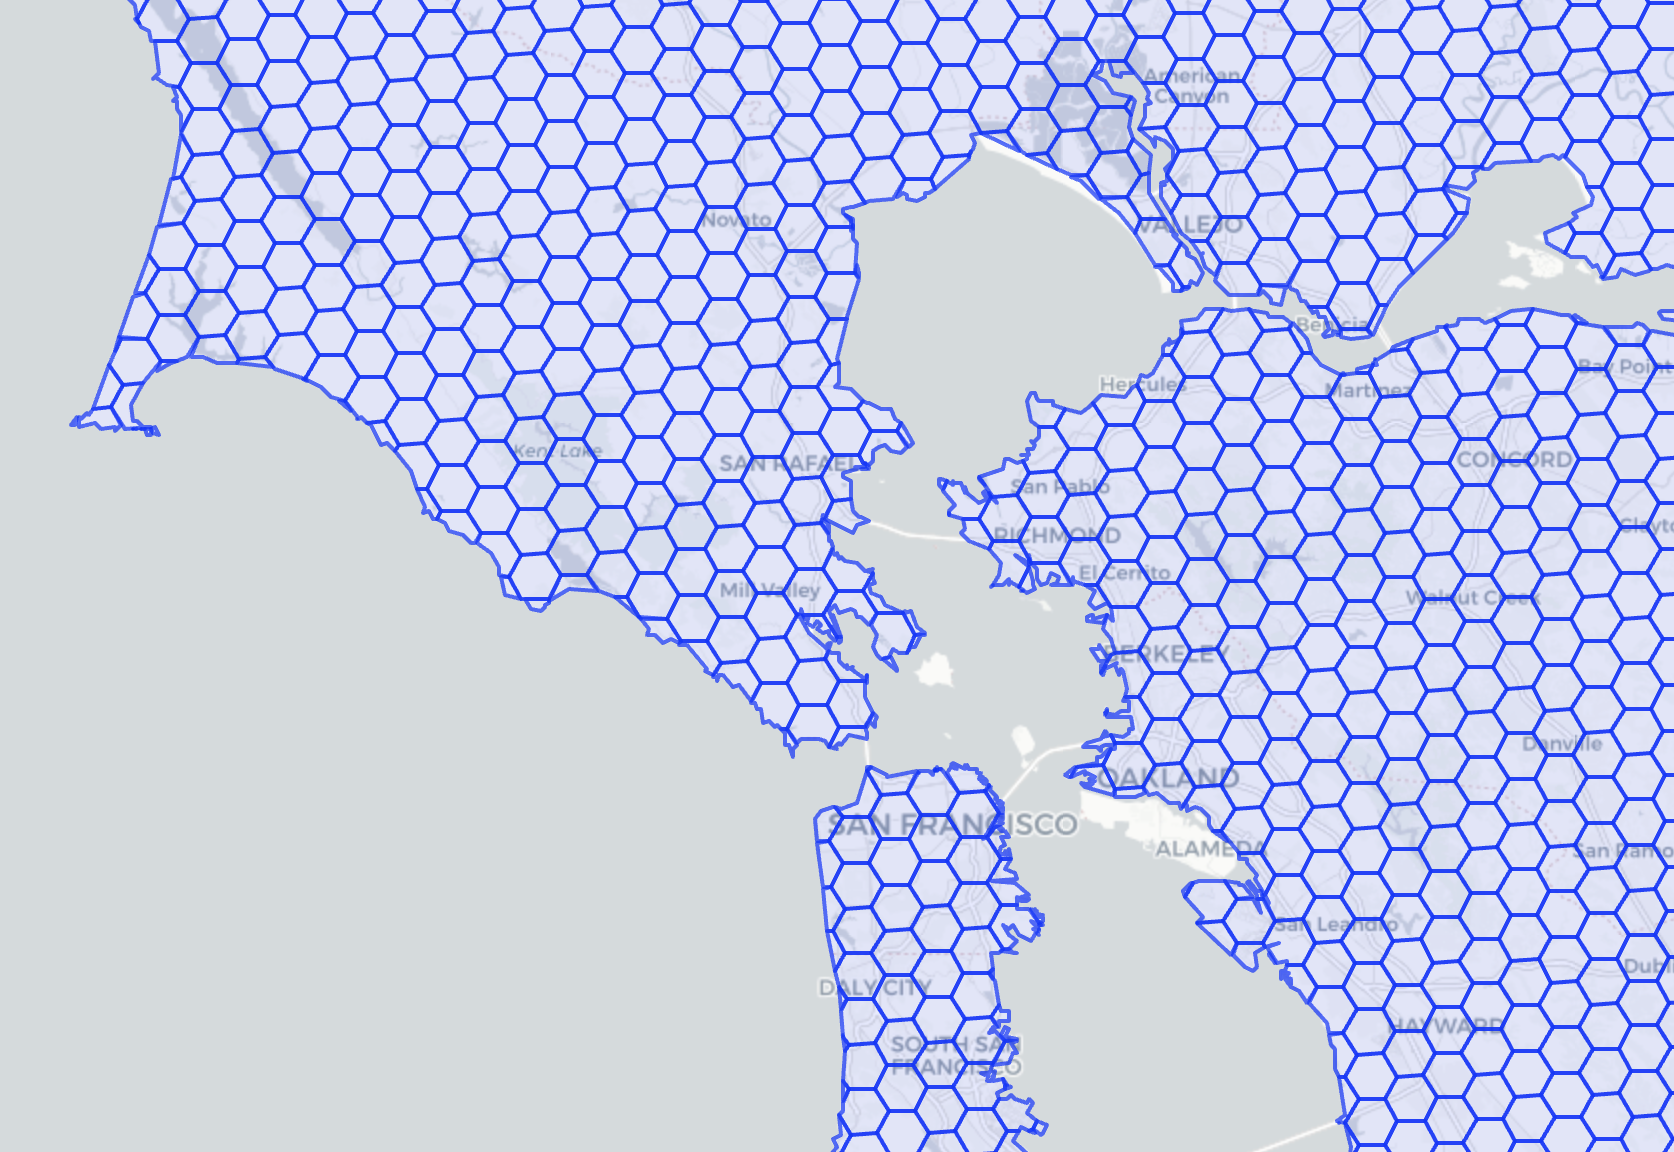

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data pre-processing

First things first, let's import all the necessary packages.

In [ ]:
!pip install rasterio
!pip install rasterstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.6 MB/s eta 0:00:00


In [ ]:
# Import packages
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import rasterstats
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from rasterio.crs import CRS
import fiona
import gdown

You can ignore the following code for know. We are running it here so as to save runtime later on in the tutorial. Essentially, the following code serves to call a geopandas dataframe stored in github. (The code that's been commented out (##) was used to download the data from Collab so it could be transferred to Github.)


In [ ]:
## inside_fire_perimeter.to_file('/content/inside_fire_perimeter.geojson', driver="GeoJSON")
## outside_fire_perimeter.to_file('/content/outside_fire_perimeter.geojson', driver="GeoJSON")

In [ ]:
inside_fire = gpd.read_file("https://github.com/elianaprosnitz/bio108tutorial/raw/refs/heads/main/data/inside_fire_perimeter.geojson")

In [ ]:
outside_fire = gpd.read_file("https://github.com/elianaprosnitz/bio108tutorial/raw/refs/heads/main/data/outside_fire_perimeter.geojson")

Connect to Google Drive to access and import the downloaded wildfire shapefile.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read in the wildfire shapefile using the filepath into Google Drive.
CA_wildfire_shp_path = '/content/drive/MyDrive/BIO 109 Data Science/California_Fire_Perimeters_(all).shp'
CA_wildfire = gpd.read_file(CA_wildfire_shp_path)

DataSourceError: Unable to open /content/drive/MyDrive/BIO 109 Data Science/California_Fire_Perimeters_(all).shx or /content/drive/MyDrive/BIO 109 Data Science/California_Fire_Perimeters_(all).SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [ ]:
#Summary statistics

Let's import high resolution species richness data for California. This time the GeoJSON file is extracted from a link.

In [ ]:
# URL to the ArcGIS GeoJSON
CA_SR_url = "https://data-cdfw.opendata.arcgis.com/api/download/v1/items/927417af9e694ad98c37a544da263db0/geojson?layers=0"

# Read the data into a GeoDataFrame
CA_SR = gpd.read_file(CA_SR_url)

Look at the summary statistics to see what might be useful to visualize. It is also useful to look at the metadata assosiated with the species richness data. Check out the [Rare Species Richness Factsheet](https://data.ca.gov/dataset/terrestrial-rare-species-richness-summary-ace-ds2709/resource/01485d2f-b0b1-4039-82cf-b039bc53d4cd).

In [ ]:
#Summary statistics

According to the Factsheet, "RarRankSW" (Rare Rank State Wide) ranks hexagons from 1-5 assigned to the statewide normalized rare species richness values, with all zero values removed and remaining values broken into 5 quantiles, each containing the same number of hexagons.

## Visualization

It is helpful to visualize our data as a **heatmap** of species richness, overlayed with the wildfire perimeter data.

In [ ]:
# Visualize/plot the data
# Reference the Rare Rank State Wide column to get a map of that specific subset
CA_SR.plot(column='RarRankSW', legend=True)

Now it would be helpful to see how the wildfire data overlaps with the species richness heatmap. HOWEVER, before we add in our wildfire data, we need to check if the Coordinate Reference Systems (CRSs) are compatable.

Refresh: CRSs are a framework for defining locations on the Earth's surface using coordinates. There are two different types: geographic and projected. Geographic essentially uses latitude and longitude and applies that to a 3D spherical/ellipsoidal model of the Earth. Projected CRS uses projection to convert GCS onto a 2D surface, and then uses linear units like meters, miles and feet.  

In [ ]:
# Species richness CRS
CA_SR.crs

In [ ]:
# Wildfire CRS
CA_wildfire.crs

Uh oh! Our dataframes are in different coordinate reference systems. The wildfire data (CA_wildfire) is in EPSG:3857 (a projected CRS), and the species richness data (CA_SR) is in EPSG:4326 (a geographic CRS). Let's convert the wildfire data into EPSG:4326 to match our base layer.

In [ ]:
# Create a new variable with the wildfire data converted in a geographic CRS.
CA_wildfire_geographic = CA_wildfire.to_crs(epsg=4326)

Now we can generate our **combined plot**. For this visualization, it is helpful to see a side-by-side of the species richness heatmap and the combined map.

In [ ]:
# Create figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharex=True, sharey=True)

# Shared style settings
vmin = CA_SR['RarRankSW'].min()
vmax = CA_SR['RarRankSW'].max()

# Left: Base layer only
CA_SR.plot(
    column='RarRankSW',
    ax=ax1, vmin=vmin, vmax=vmax
)
ax1.set_title("Rare Species (Base Layer Only)")
ax1.set_axis_off()

# Right: Base layer and wildfire data
CA_SR.plot(
    column='RarRankSW',
    ax=ax2, vmin=vmin, vmax=vmax
)
CA_wildfire_geographic.plot(ax=ax2, facecolor='red', edgecolor='red', alpha = 0.5, linewidth=1)
ax2.set_title("Rare Species + Wildfire Overlay")
ax2.set_axis_off()

plt.tight_layout()
plt.show()

This is a pretty cool map! It seems like there is some association with yellow areas of the heatmap and the fire perimeter, but it is a bit difficult to interpret what is really going on. How can we confirm numerically that there is a difference between fire and non-fire regions?

## Statistical analysis: Calculating means

In order to more precisely compare species richness inside and outside of fire perimeters, it would be good to calculate a represenative statistic. In this case, we will find the mean species richness in overlapping areas as opposed to the mean in non-overlapping areas. Python can isolate areas of overlap pretty easily using an overlay function.
```
# Overlapping data
gpd.overlay (dataset1, dataset2, how='intersection')

# Non-overlapping data
gpd.overlay (dataset1, dataset2, how='difference')
```
The overlapping data will be the regions that experienced wildfire damage. The rest falls into the non-overlapping data.

In [ ]:
# Define the overlapping area using the gpd.overlap 'intersection' function.
inside_fire_perimeter = gpd.overlay(CA_SR, CA_wildfire_geographic, how='intersection')

In [ ]:
# Define the NON-overlapping area using the gpd.overlap 'difference' function.
outside_fire_perimeter = gpd.overlay(CA_SR, CA_wildfire_geographic, how='difference')

*NOTE: We are not going to run the above code right now, as these files are HUGE and the intersection command can take a couple minutes to complete. Luckily, we saved those handy variables earlier in the tutorial and can call them in below.*

In [ ]:
# Calculate the mean species richness inside fire perimeters and print the result.
inside_meanSR = inside_fire['RarRankSW'].mean()
print(inside_meanSR)

In [ ]:
# Calculate the mean species richness outside fire perimeters and print the result.
outside_meanSR = outside_fire['RarRankSW'].mean()
print(outside_meanSR)

## Results


There is a positive correlation between wildfires and species richness. This is visible in the plots, but is more clearly reflected in the mean species richness results. The mean SR outside of the fire perimeter is lower (2.59) than inside the fire perimeter (3.35).

Correlation (famously) does not mean causation. It could be that there is higher species richness in regions more susceptible to fire danger. However, it could also reflect that wildfires promote habitat diversity and regeneration. These findings are in agreement with the paper referenced at the start of this markdown.

**Conservation Significance**
Wildfires are often viewed solely as destructive forces, but this analysis shows that they play a vital ecological role in maintaining and enhancing biodiversity. In fire-adapted ecosystems, periodic burns can create a mosaic of habitats that support a wider range of species (i.e., those dependent on early successional environments). Understanding this dynamic helps inform fire management policies. Rather than universally suppressing fires, land management practice could shift towards prescribed burns and allowing natural fires under controlled conditions. This shift would promote long-term ecosystem health and greater species resilience.

